In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable
from tqdm import tqdm
from SPR_run_1D import * 
import pandas as pd
plt.style.use('../publication.mplstyle')

/home/combette/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
params = dict( 
              amp  = np.logspace(-3,0.5, 15),
              L = np.arange(7, 20, 1),
              Nx = [5000],
              lcx = np.linspace(0.1, 1, 15),
              n_samples = [1000])


In [4]:
wrapper = SPR_wrapper(params = params)

In [5]:
wrapper.run_wrapper()

/home/combette/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [46]:
res = wrapper.results, wrapper.td0

In [3]:
from sklearn.model_selection import ParameterGrid
mesh = ParameterGrid(params)

In [59]:
results = pd.DataFrame(mesh).join(pd.DataFrame(res[0].values(), columns = [f'distr_{i}' for i in range(len(res[0][0]))])).join(pd.DataFrame(res[1].values(), columns= ['td0'],)).drop(columns = ['Nx', 'n_samples', 'Unnamed: 0'])


In [ ]:
results['log-amp'] = np.log(results['amp'])
results.drop(columns = ['amp'], inplace = True)
results.fillna(0, inplace = True)

In [40]:
results.to_csv('results.csv')

RESULTS ANALYSIS

In [18]:
results = pd.read_csv('results.csv')

<AxesSubplot:>

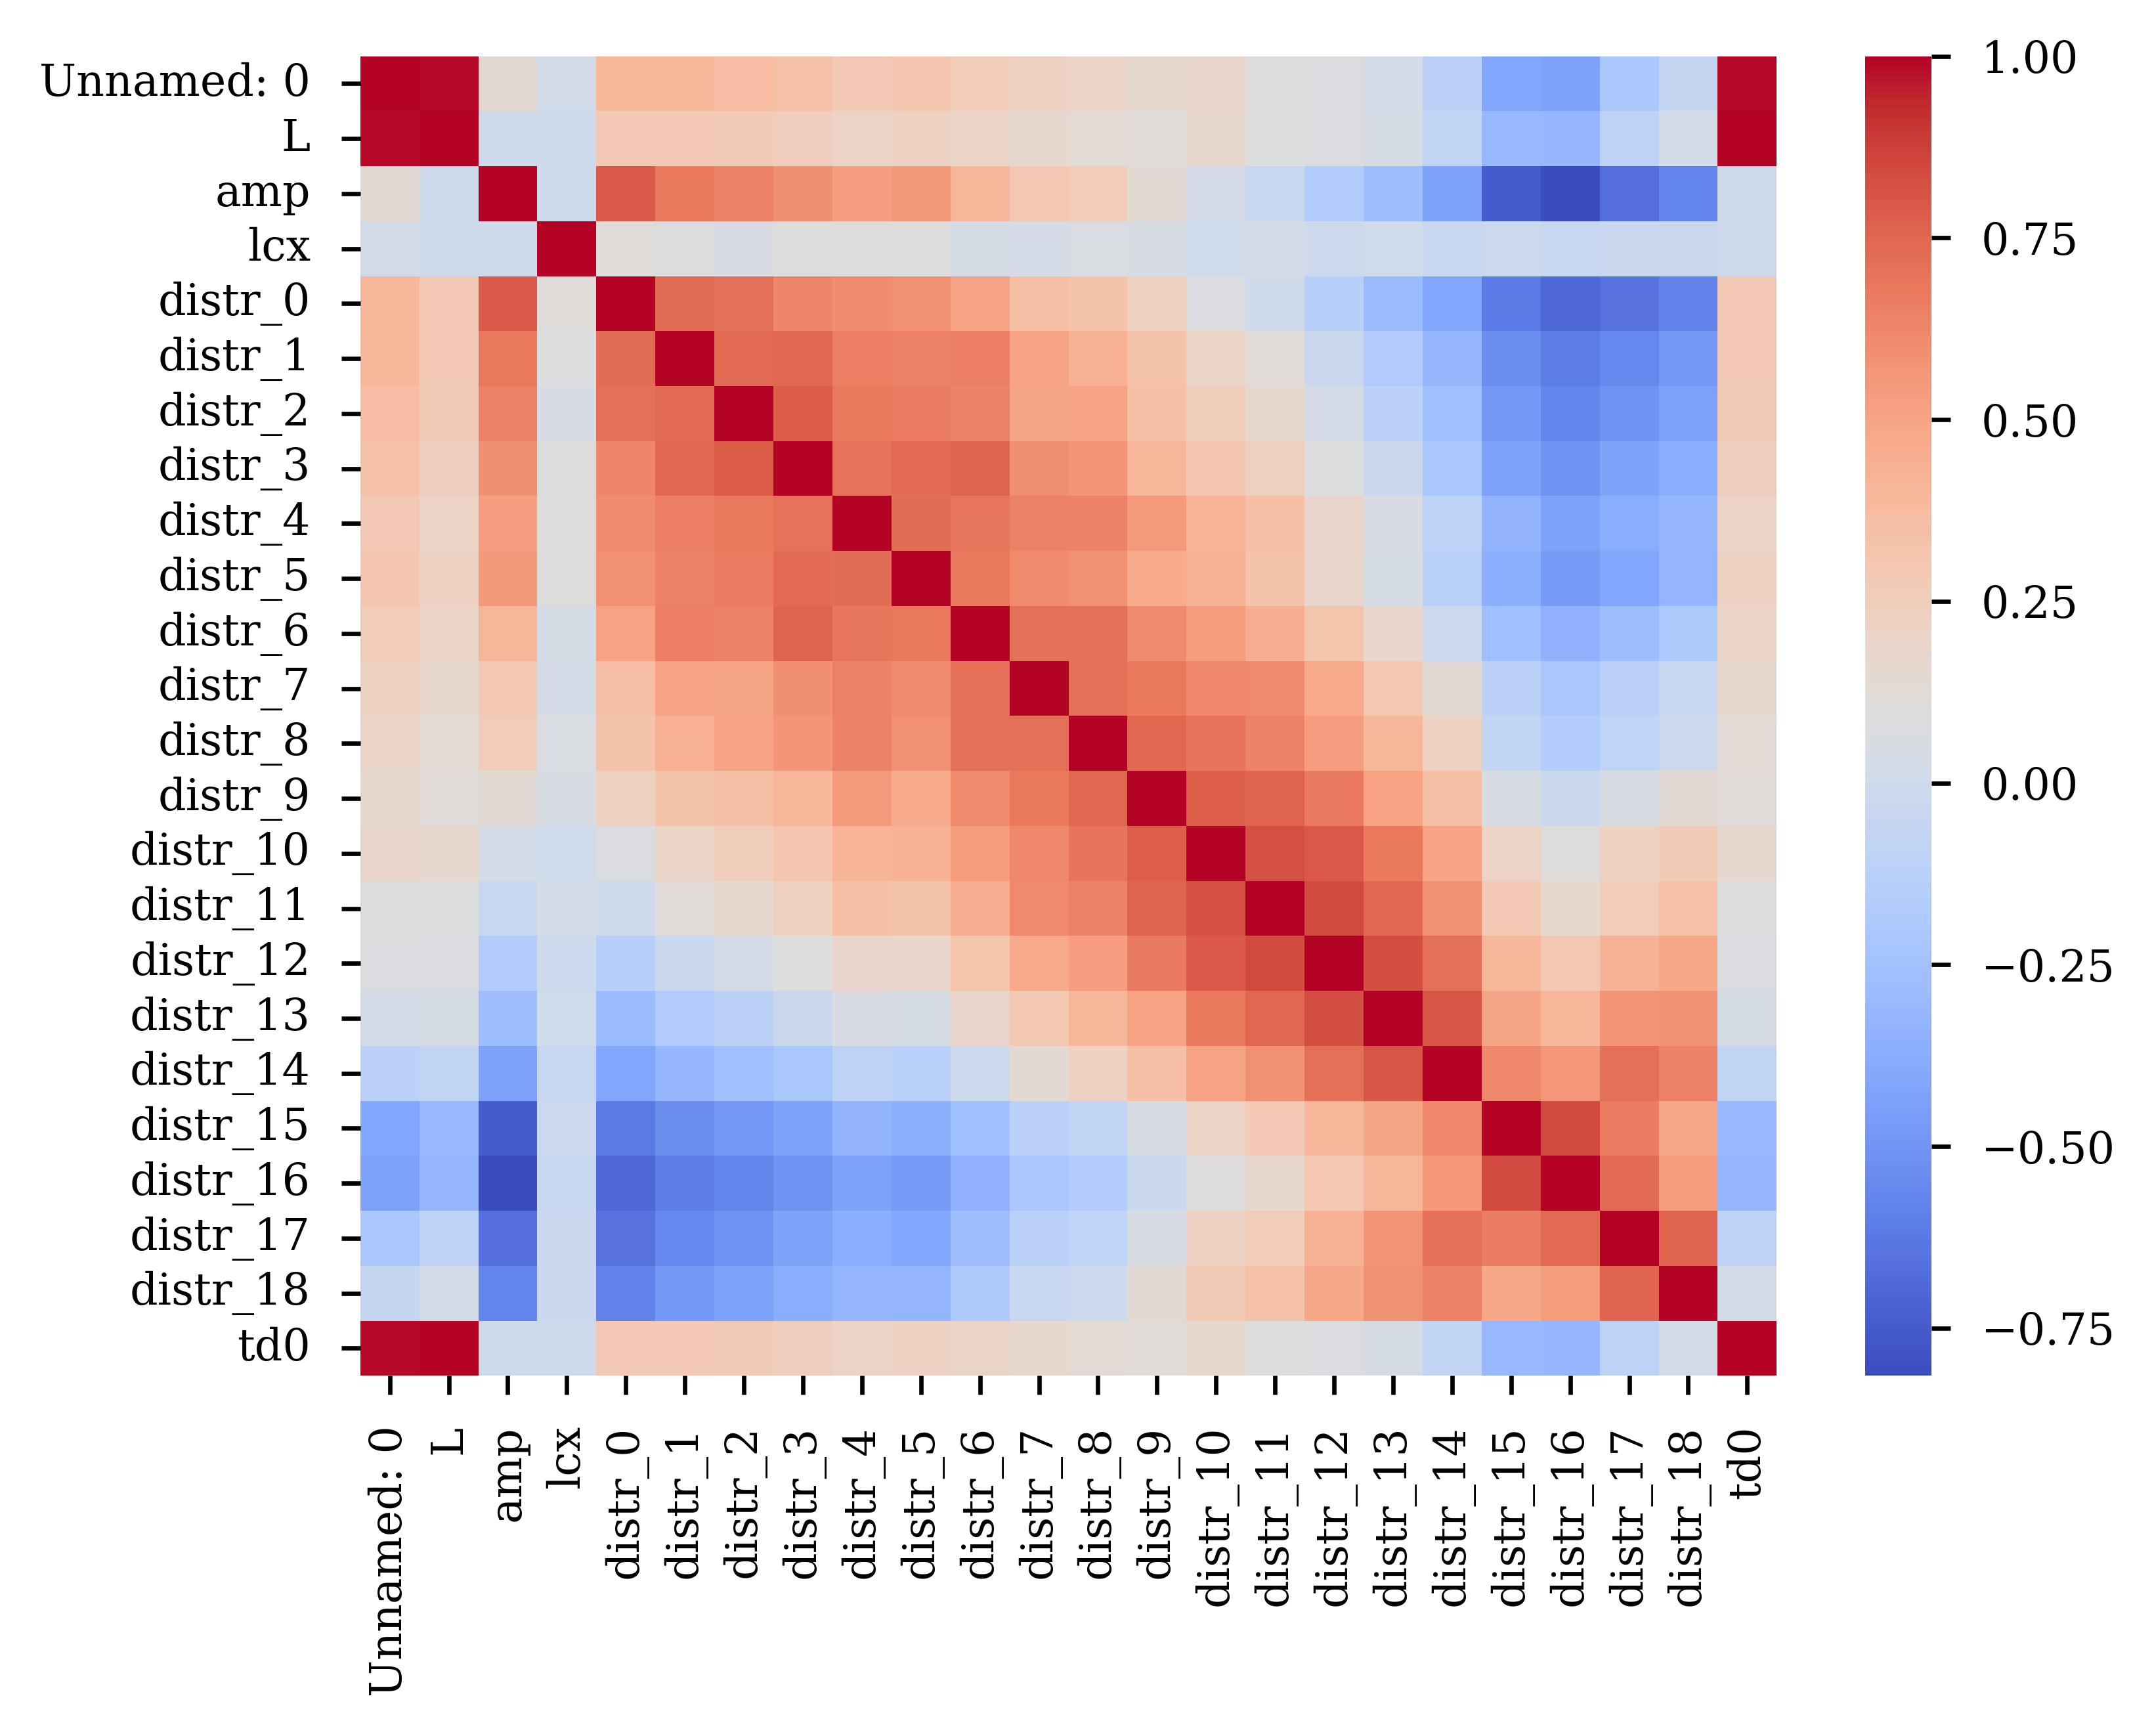

In [5]:
import seaborn as sns

sns.heatmap(results.corr('spearman'), cmap='coolwarm')

LINEAR MODEL

In [14]:
from sklearn import linear_model

In [15]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(results.drop(columns = ['td0', 'log-amp'], inplace = False), results[['td0', 'log-amp']], test_size=0.2, random_state=42)

In [42]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [43]:
reg.score(X_test, y_test)

0.23265393735971623

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
svr = KNeighborsRegressor()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.5318391307551114

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(results)

In [22]:
Y_pred = svr.predict(X_test)
final_mesh = pd.concat([X_test, pd.DataFrame(Y_pred, columns=['td'])], axis=1)
transform_mesh = pca.transform(final_mesh)

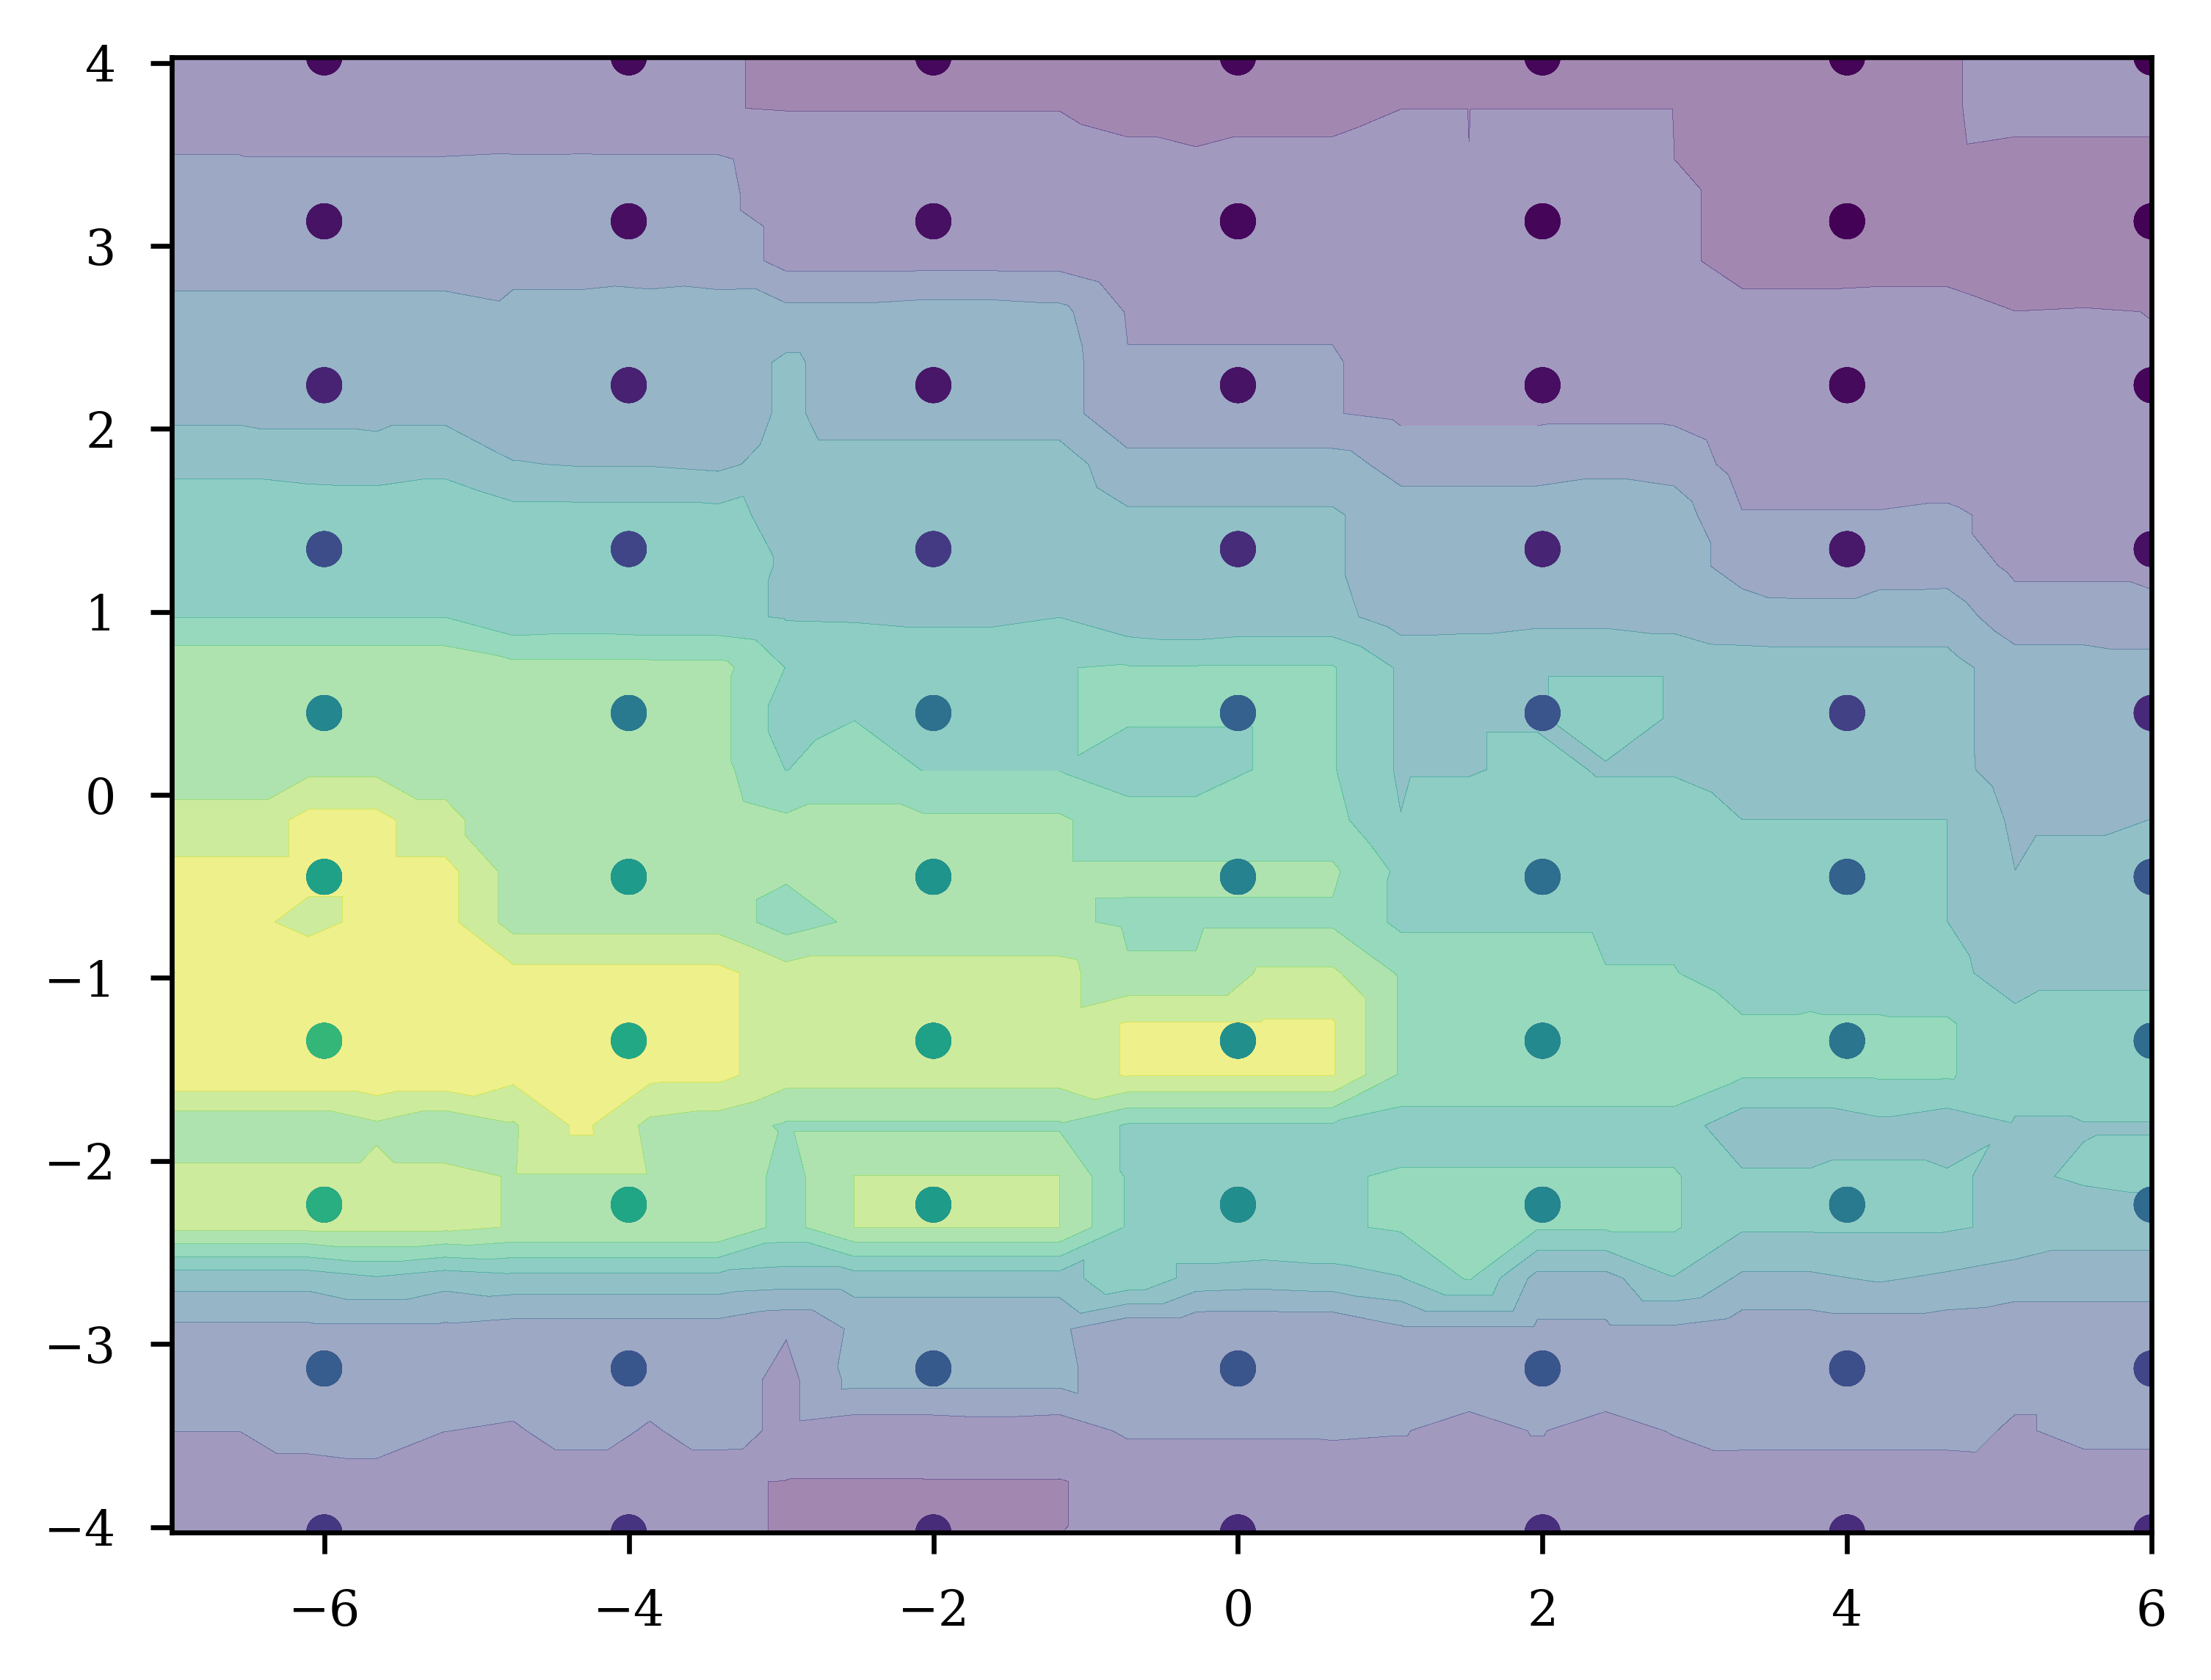

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].tricontourf(data[:,0], data[:,1], results['log-amp'], levels=10, alpha = .5)
ax[0].scatter(transform_mesh[:,0], transform_mesh[:,1], c=results['log-amp'], cmap  = 'viridis')

ax[1].tricontourf(data[:,0], data[:,1], results['td0'], levels=10, alpha = .5)
ax[1].scatter(data[:,0], data[:,1], c=results['td0'], cmap  = 'viridis')


GAUSSIAN PROCESS

In [50]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [51]:
GPR = GaussianProcessRegressor()
GPR.fit(X_train, y_train)


GaussianProcessRegressor()

In [52]:
GPR.score(X_test, y_test)

-1.3451992608250998

In [27]:
Y_pred = GPR.predict(test[['L','log-amp', 'lcx']])
final_mesh = pd.concat([test, pd.DataFrame(Y_pred, columns=['td'])], axis=1)
transform_mesh = pca.transform(final_mesh[['L', 'log-amp', 'lcx', 'td']])

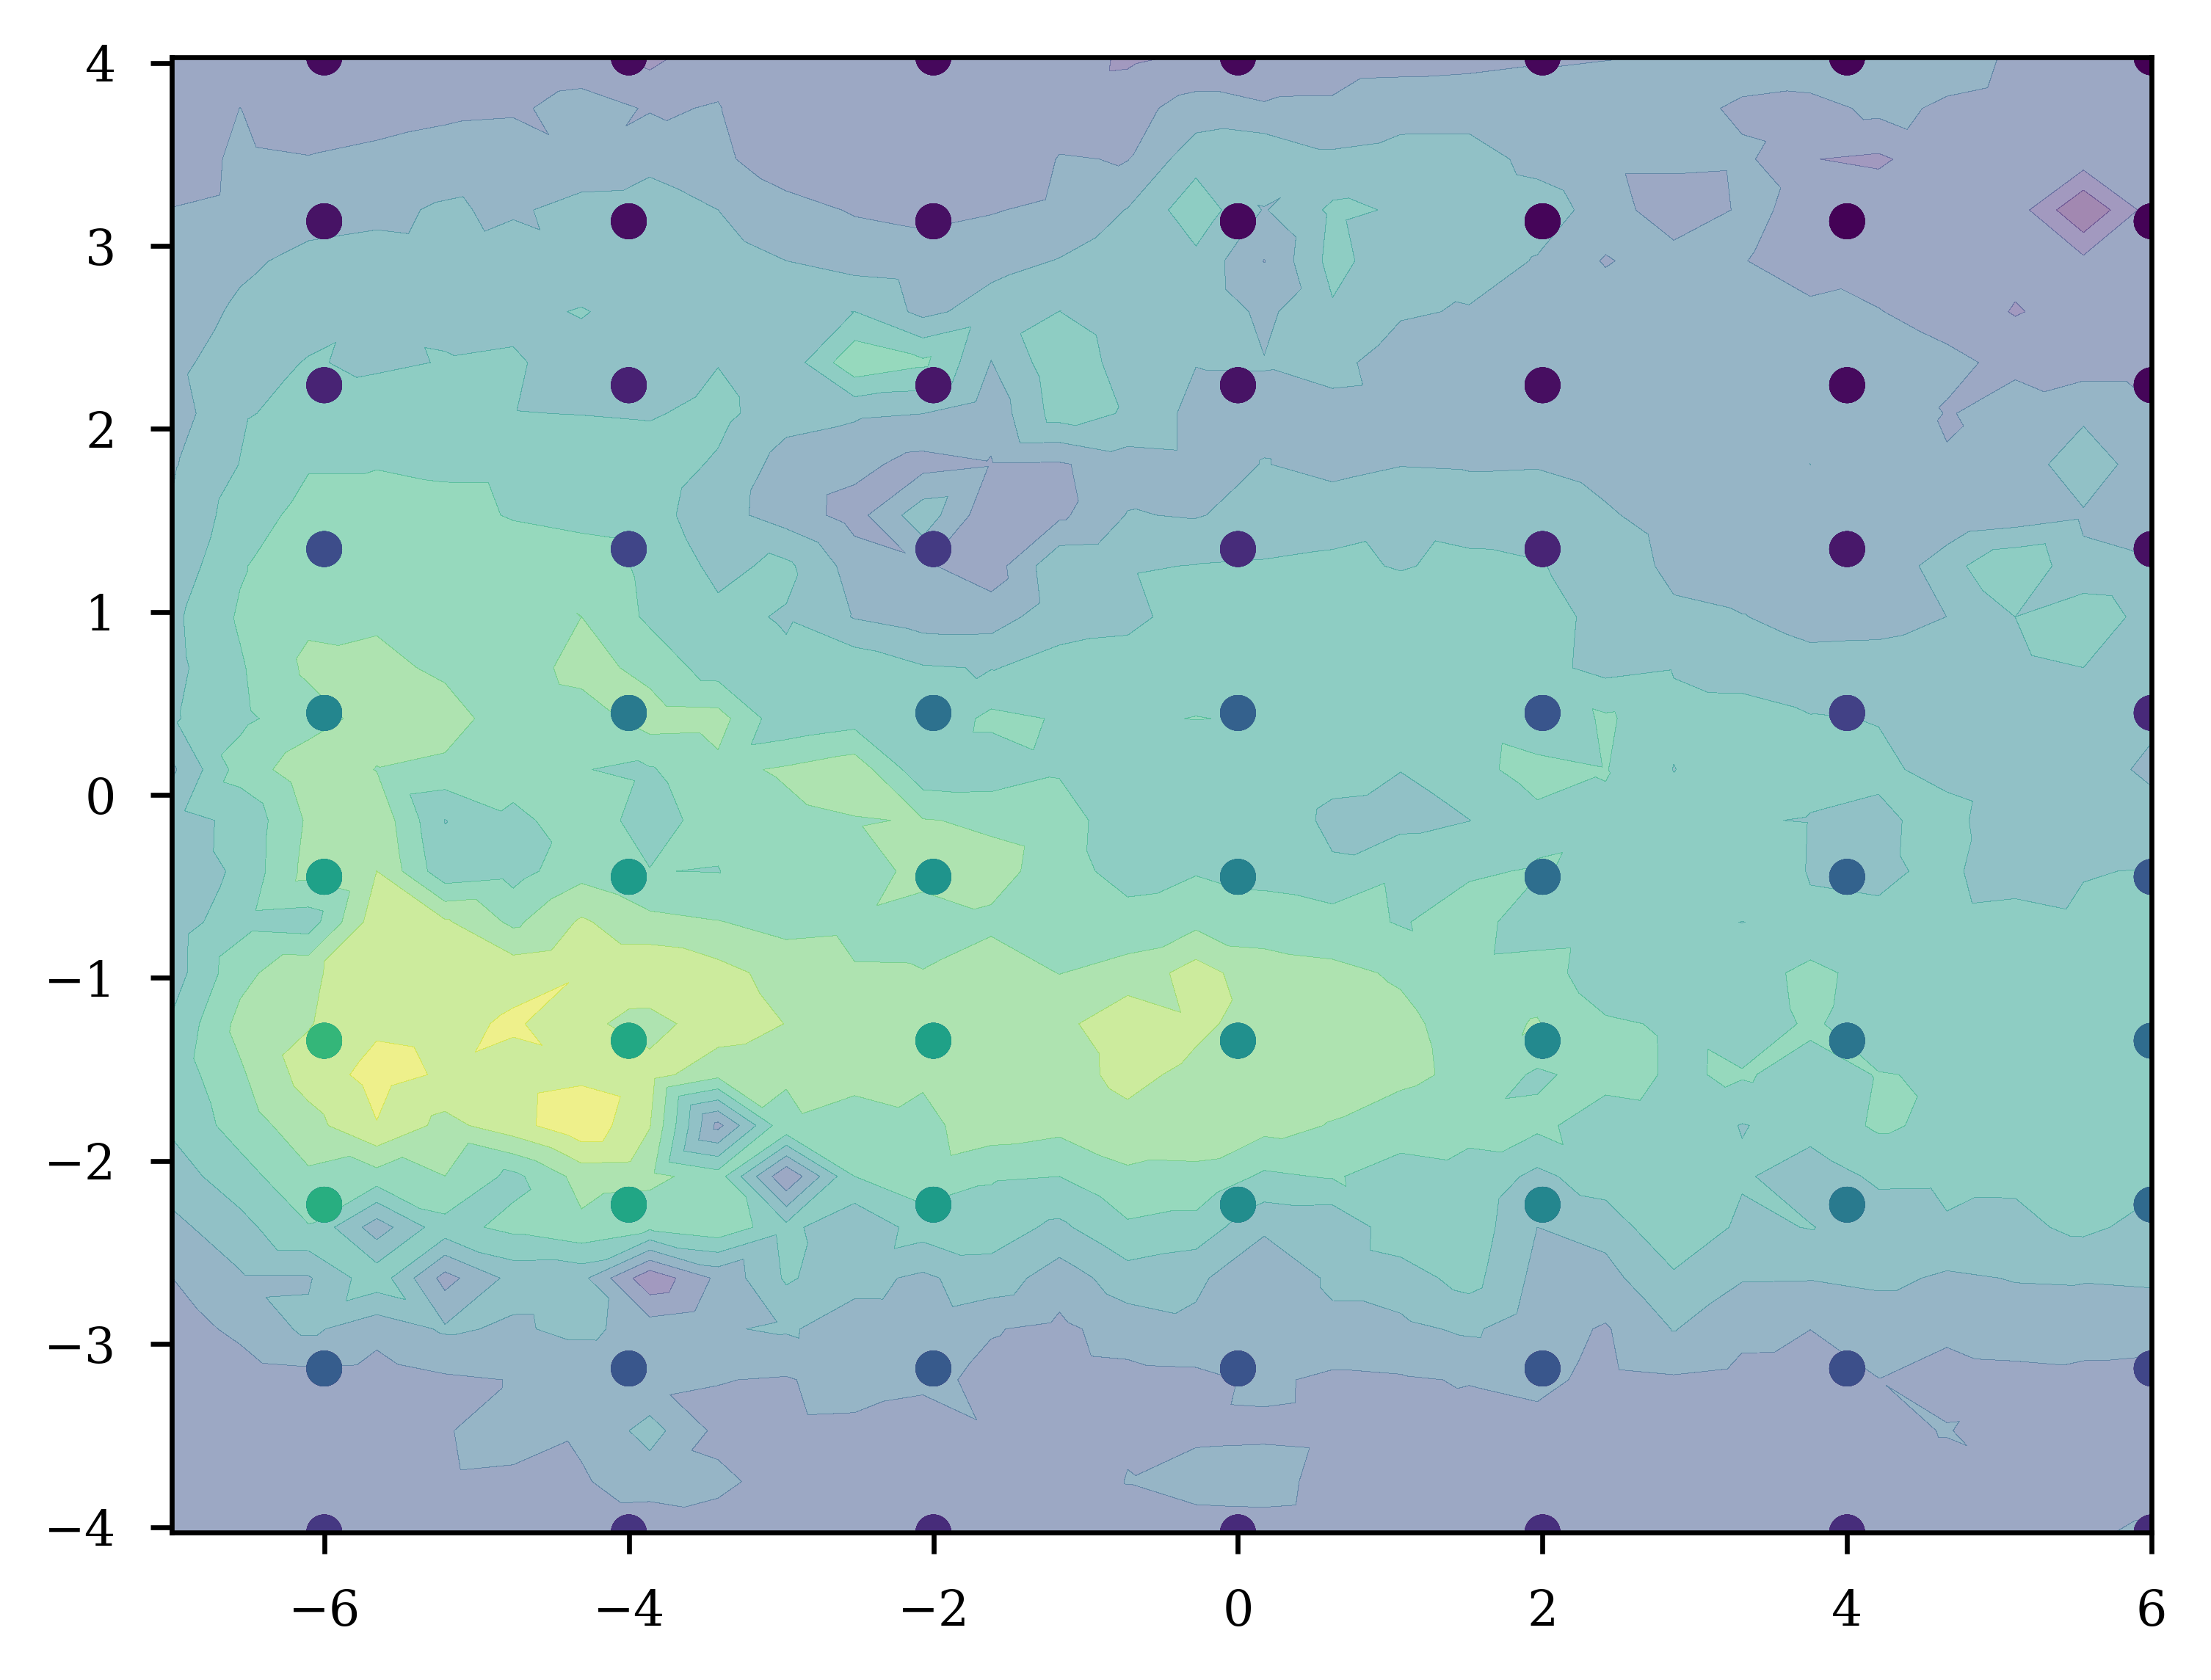

In [28]:
fig, ax = plt.subplots()
ax.tricontourf(transform_mesh[:,0], transform_mesh[:,1], final_mesh['td'], levels=10, alpha = .5)
ax.scatter(data[:,0], data[:,1], c=results['td'], cmap  = 'viridis')

RANDOM FOREST 

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
RFR = RandomForestRegressor(max_depth=10, n_estimators=100, criterion='absolute_error')
RFR.fit(X_train, y_train)
RFR.score(X_test, y_test)

0.6242327111262016

In [ ]:
Y_pred = RFR.predict(test[['L','log-amp', 'lcx']])
final_mesh = pd.concat([test, pd.DataFrame(Y_pred, columns=['td'])], axis=1)
transform_mesh = pca.transform(final_mesh[['L', 'log-amp', 'lcx', 'td']])

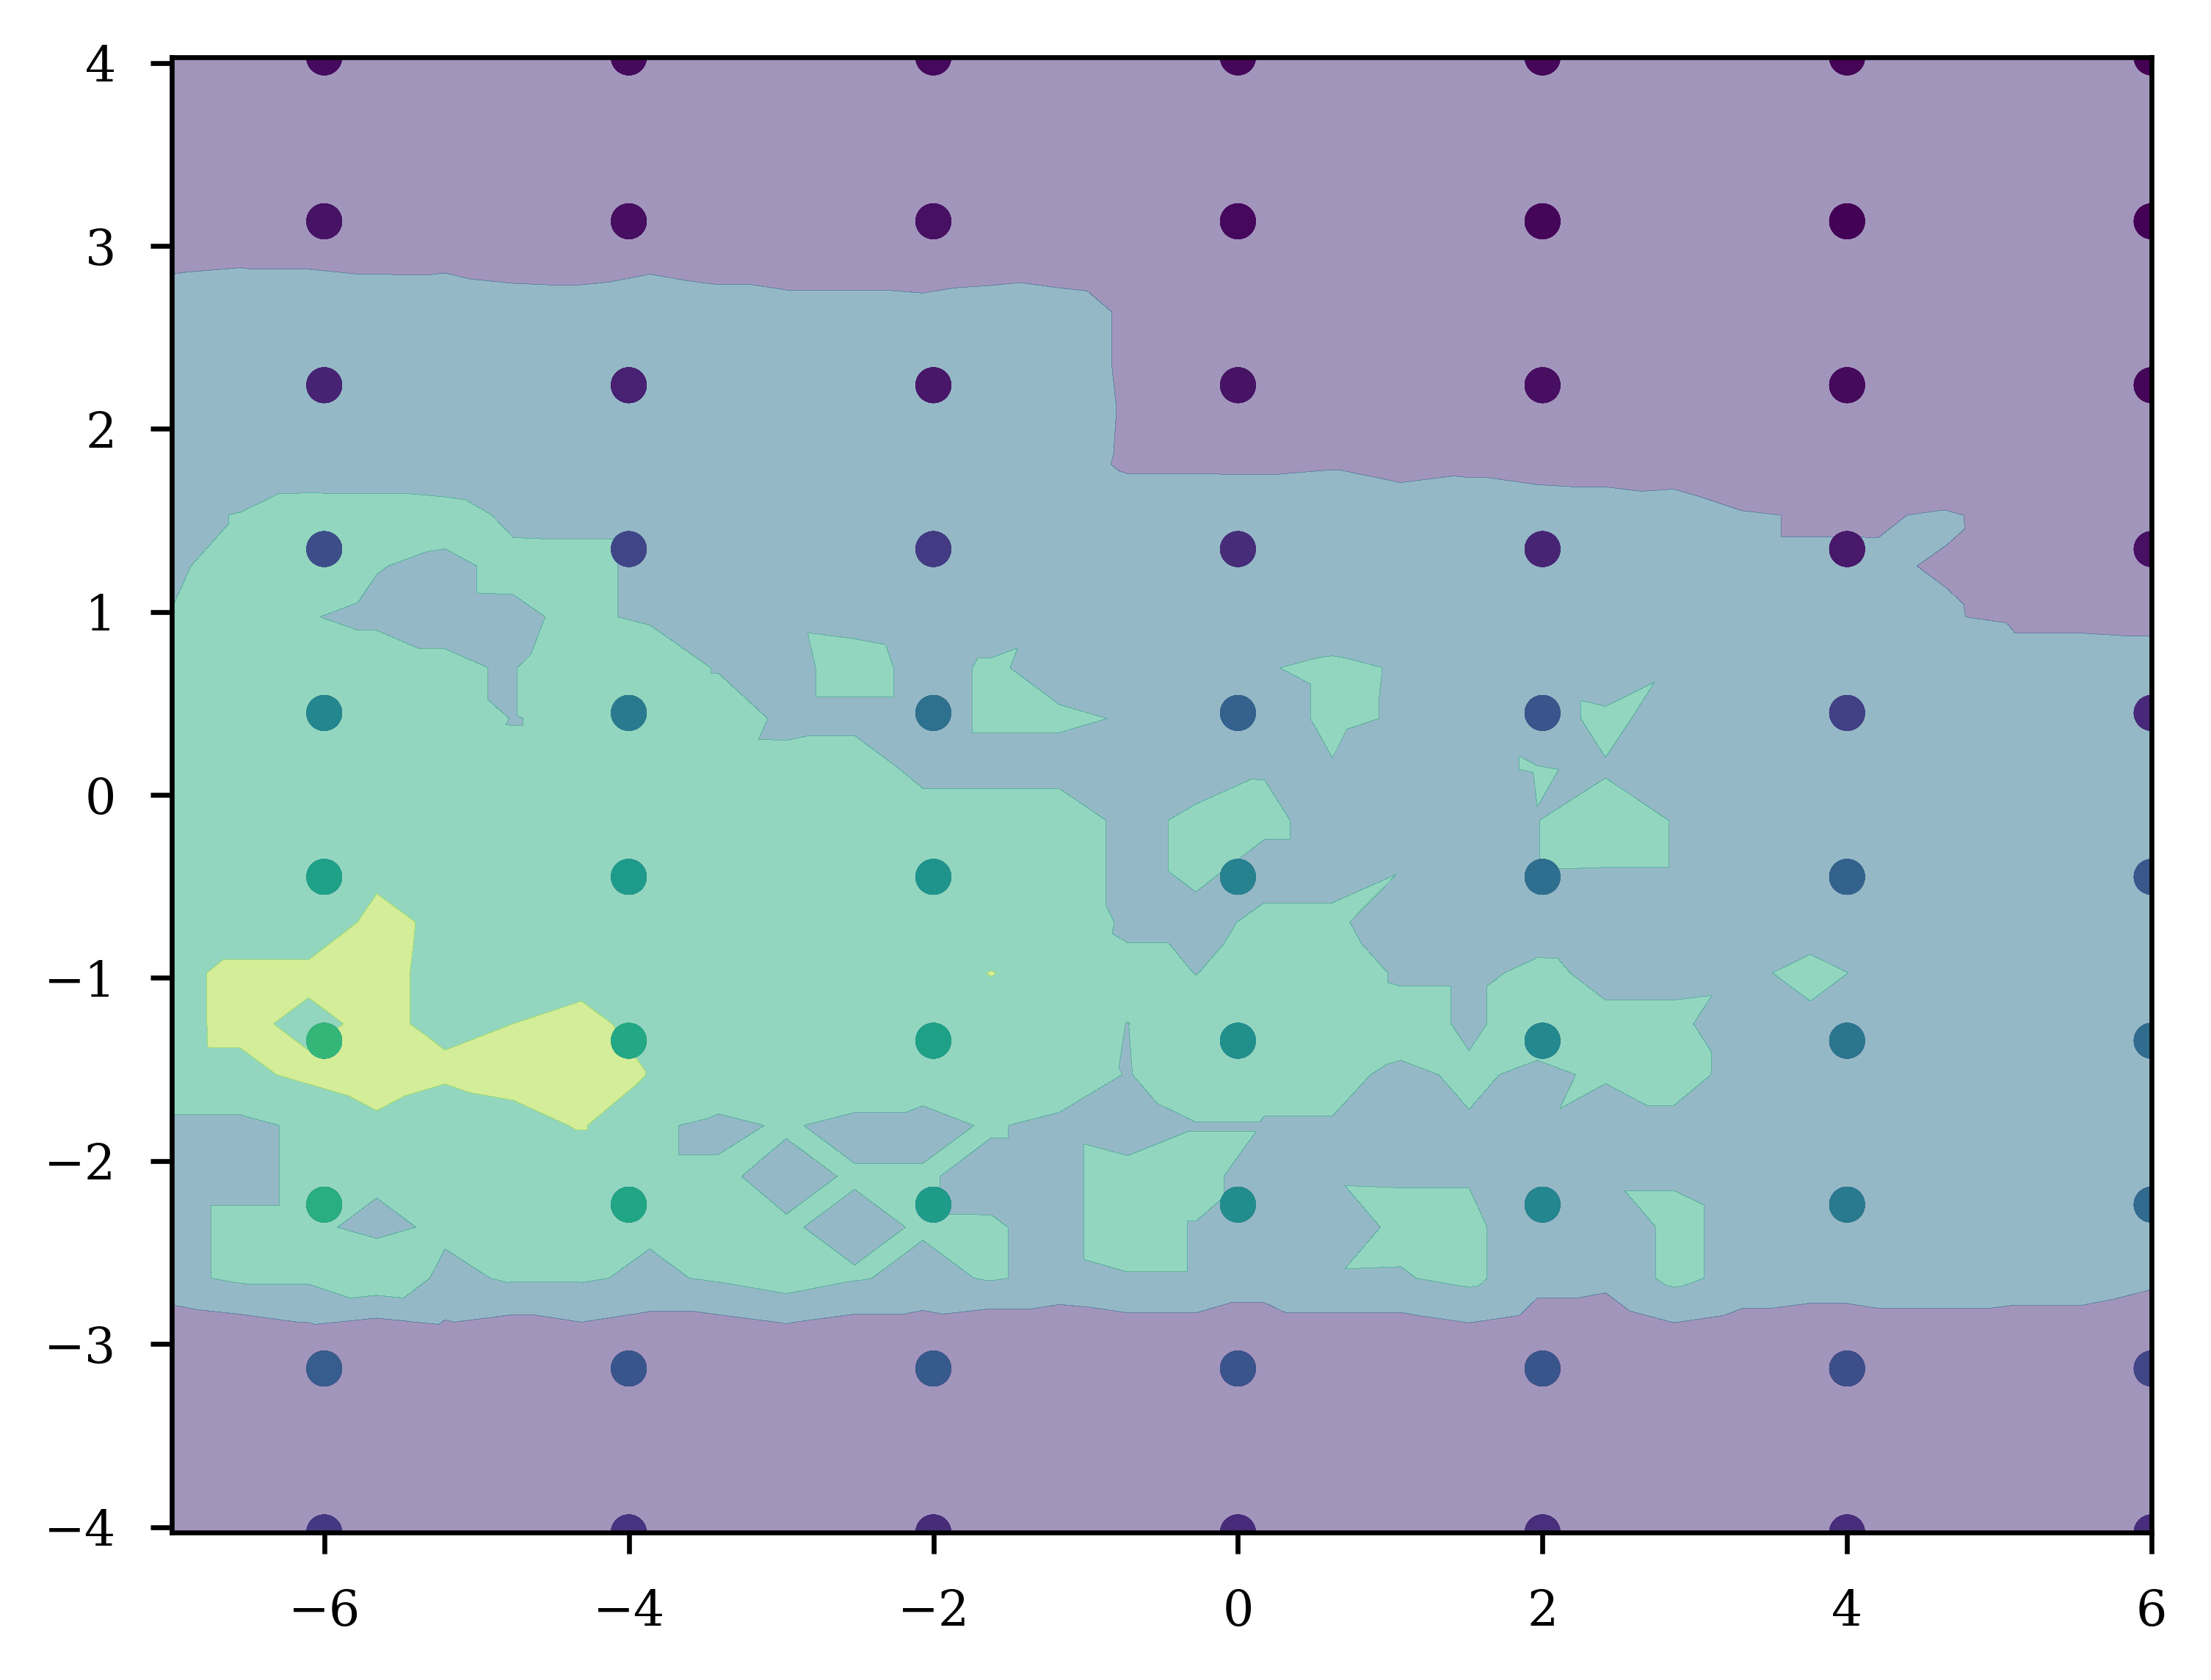

In [32]:
fig, ax = plt.subplots()
ax.tricontourf(transform_mesh[:,0], transform_mesh[:,1], final_mesh['td'], levels=3, alpha = .5)
ax.scatter(data[:,0], data[:,1], c=results['td'], cmap  = 'viridis')

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, loss = 'absolute_error')
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [35]:
Y_pred = reg.predict(test[['L','log-amp', 'lcx']])
final_mesh = pd.concat([test, pd.DataFrame(Y_pred, columns=['td'])], axis=1)
transform_mesh = pca.transform(final_mesh[['L', 'log-amp', 'lcx', 'td']])

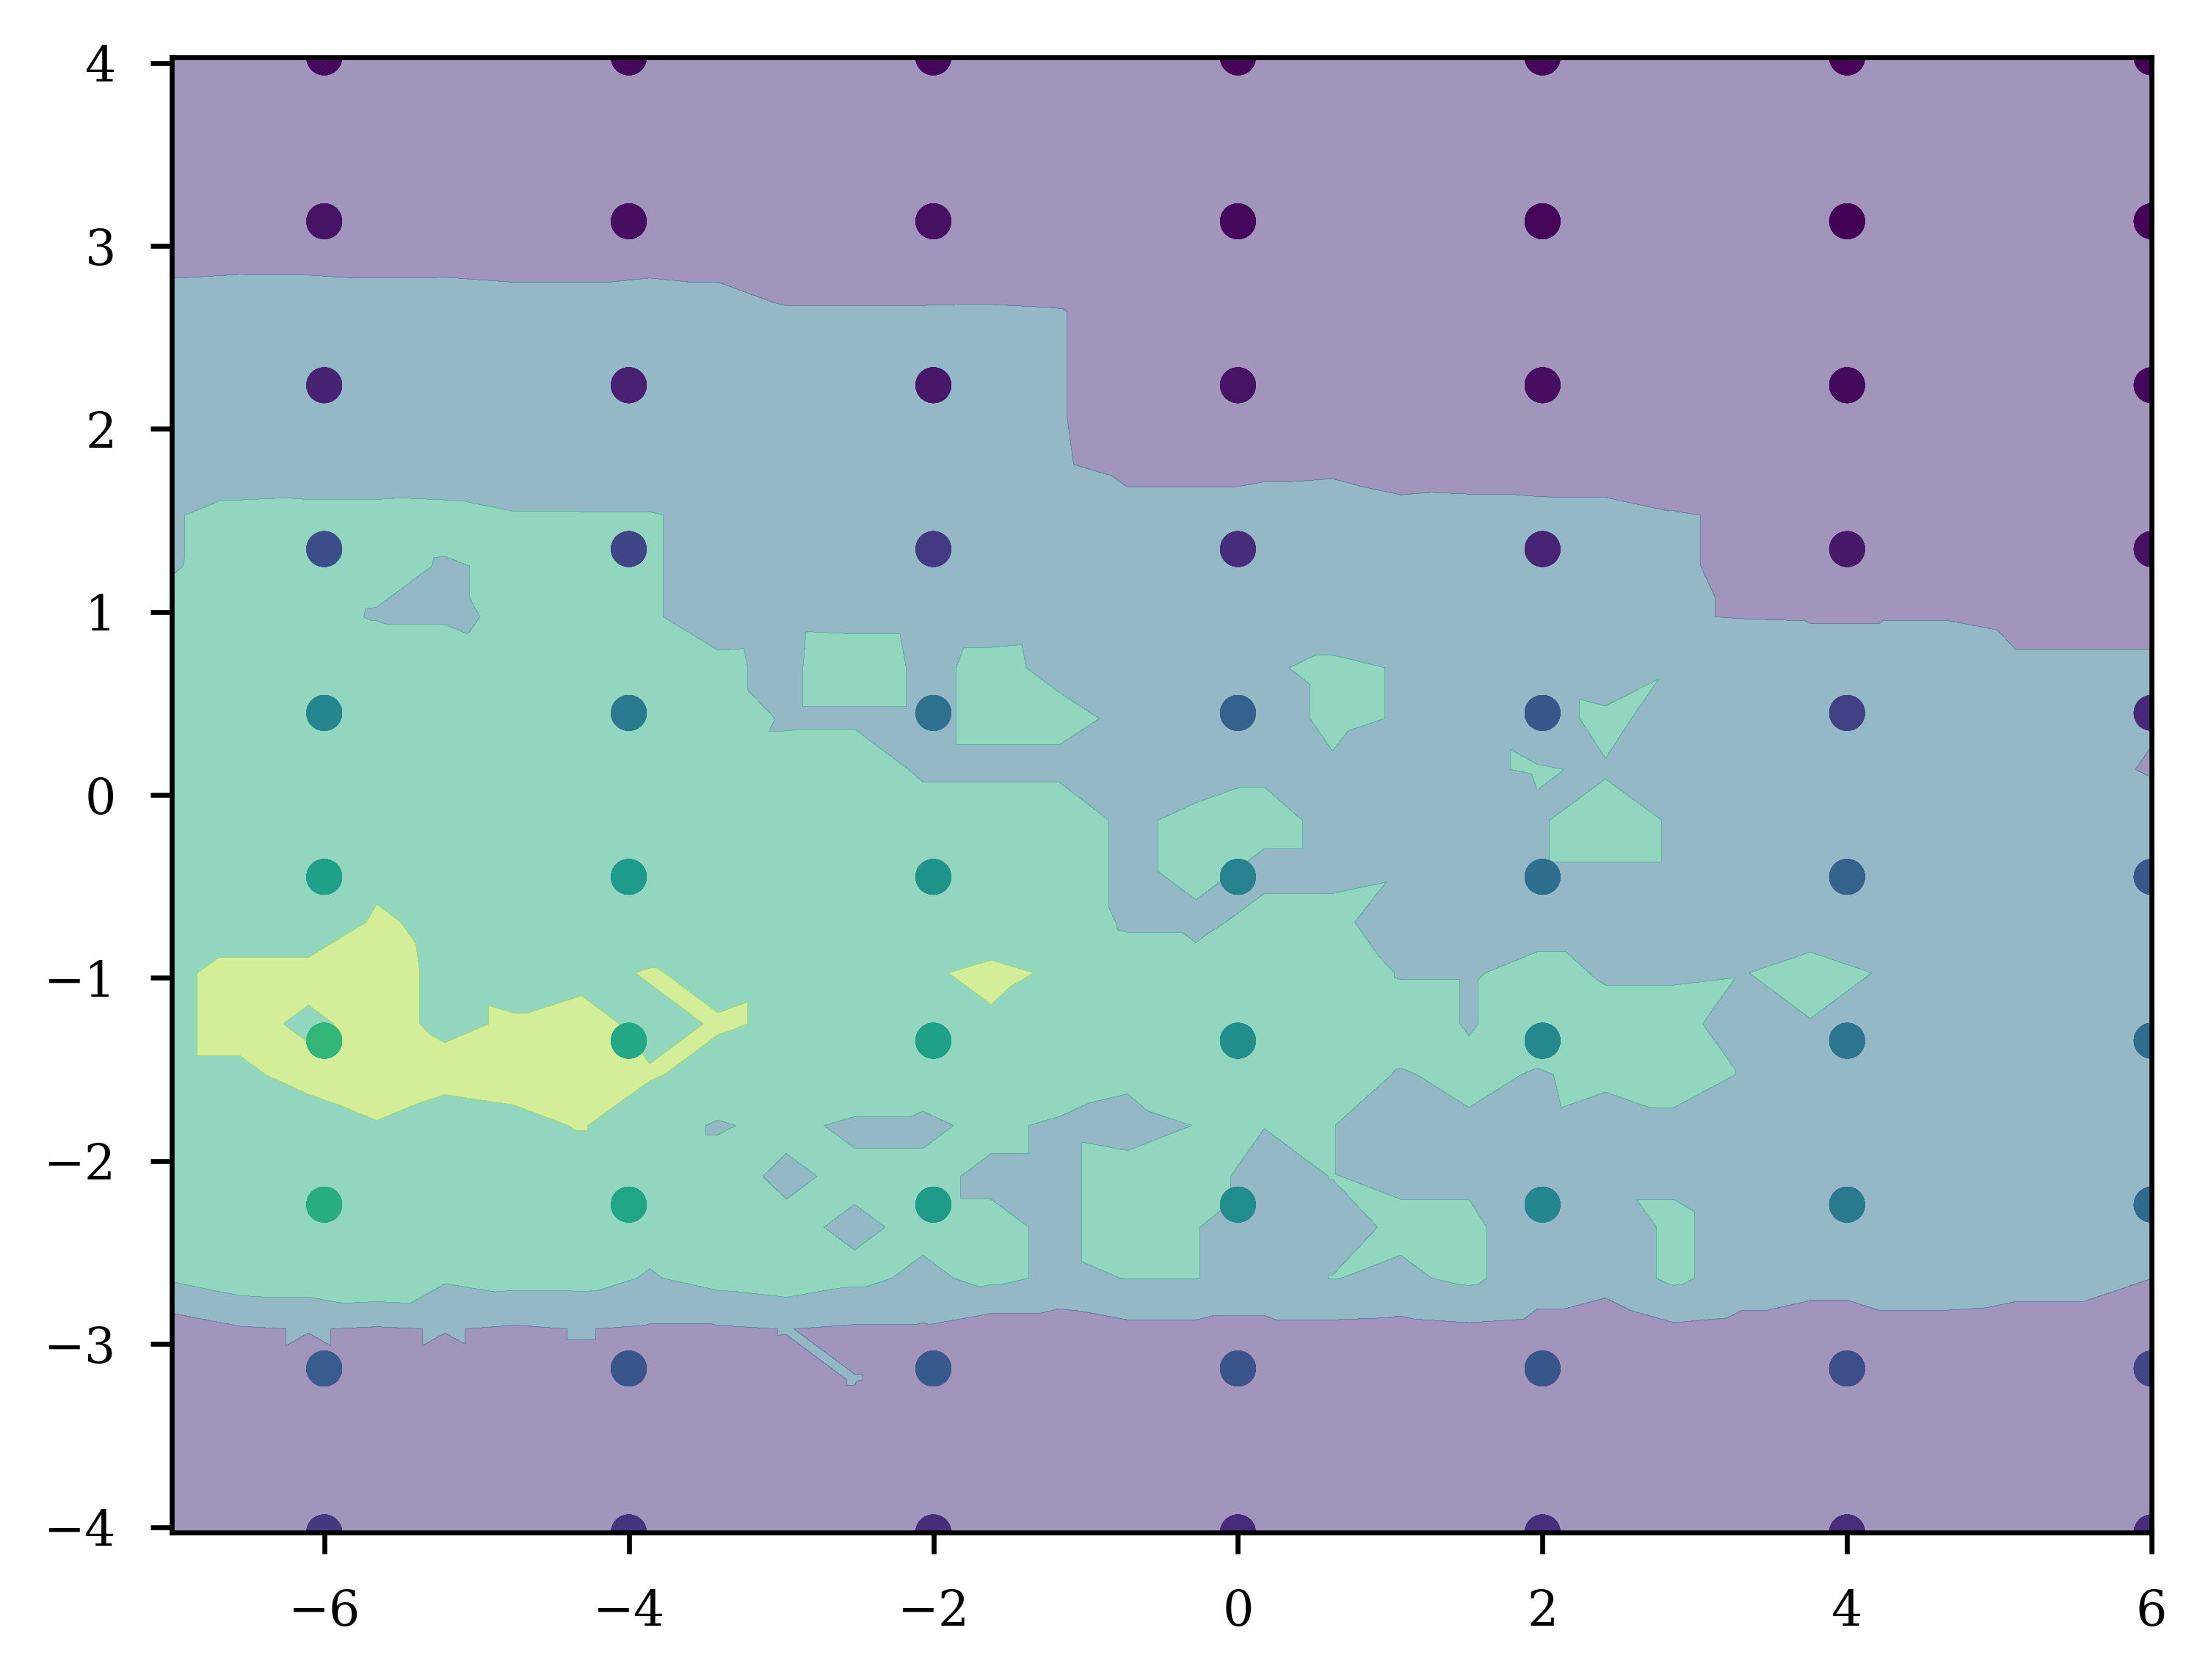

In [36]:
fig, ax = plt.subplots()
ax.tricontourf(transform_mesh[:,0], transform_mesh[:,1], final_mesh['td'], levels=3, alpha = .5)
ax.scatter(data[:,0], data[:,1], c=results['td'], cmap  = 'viridis')

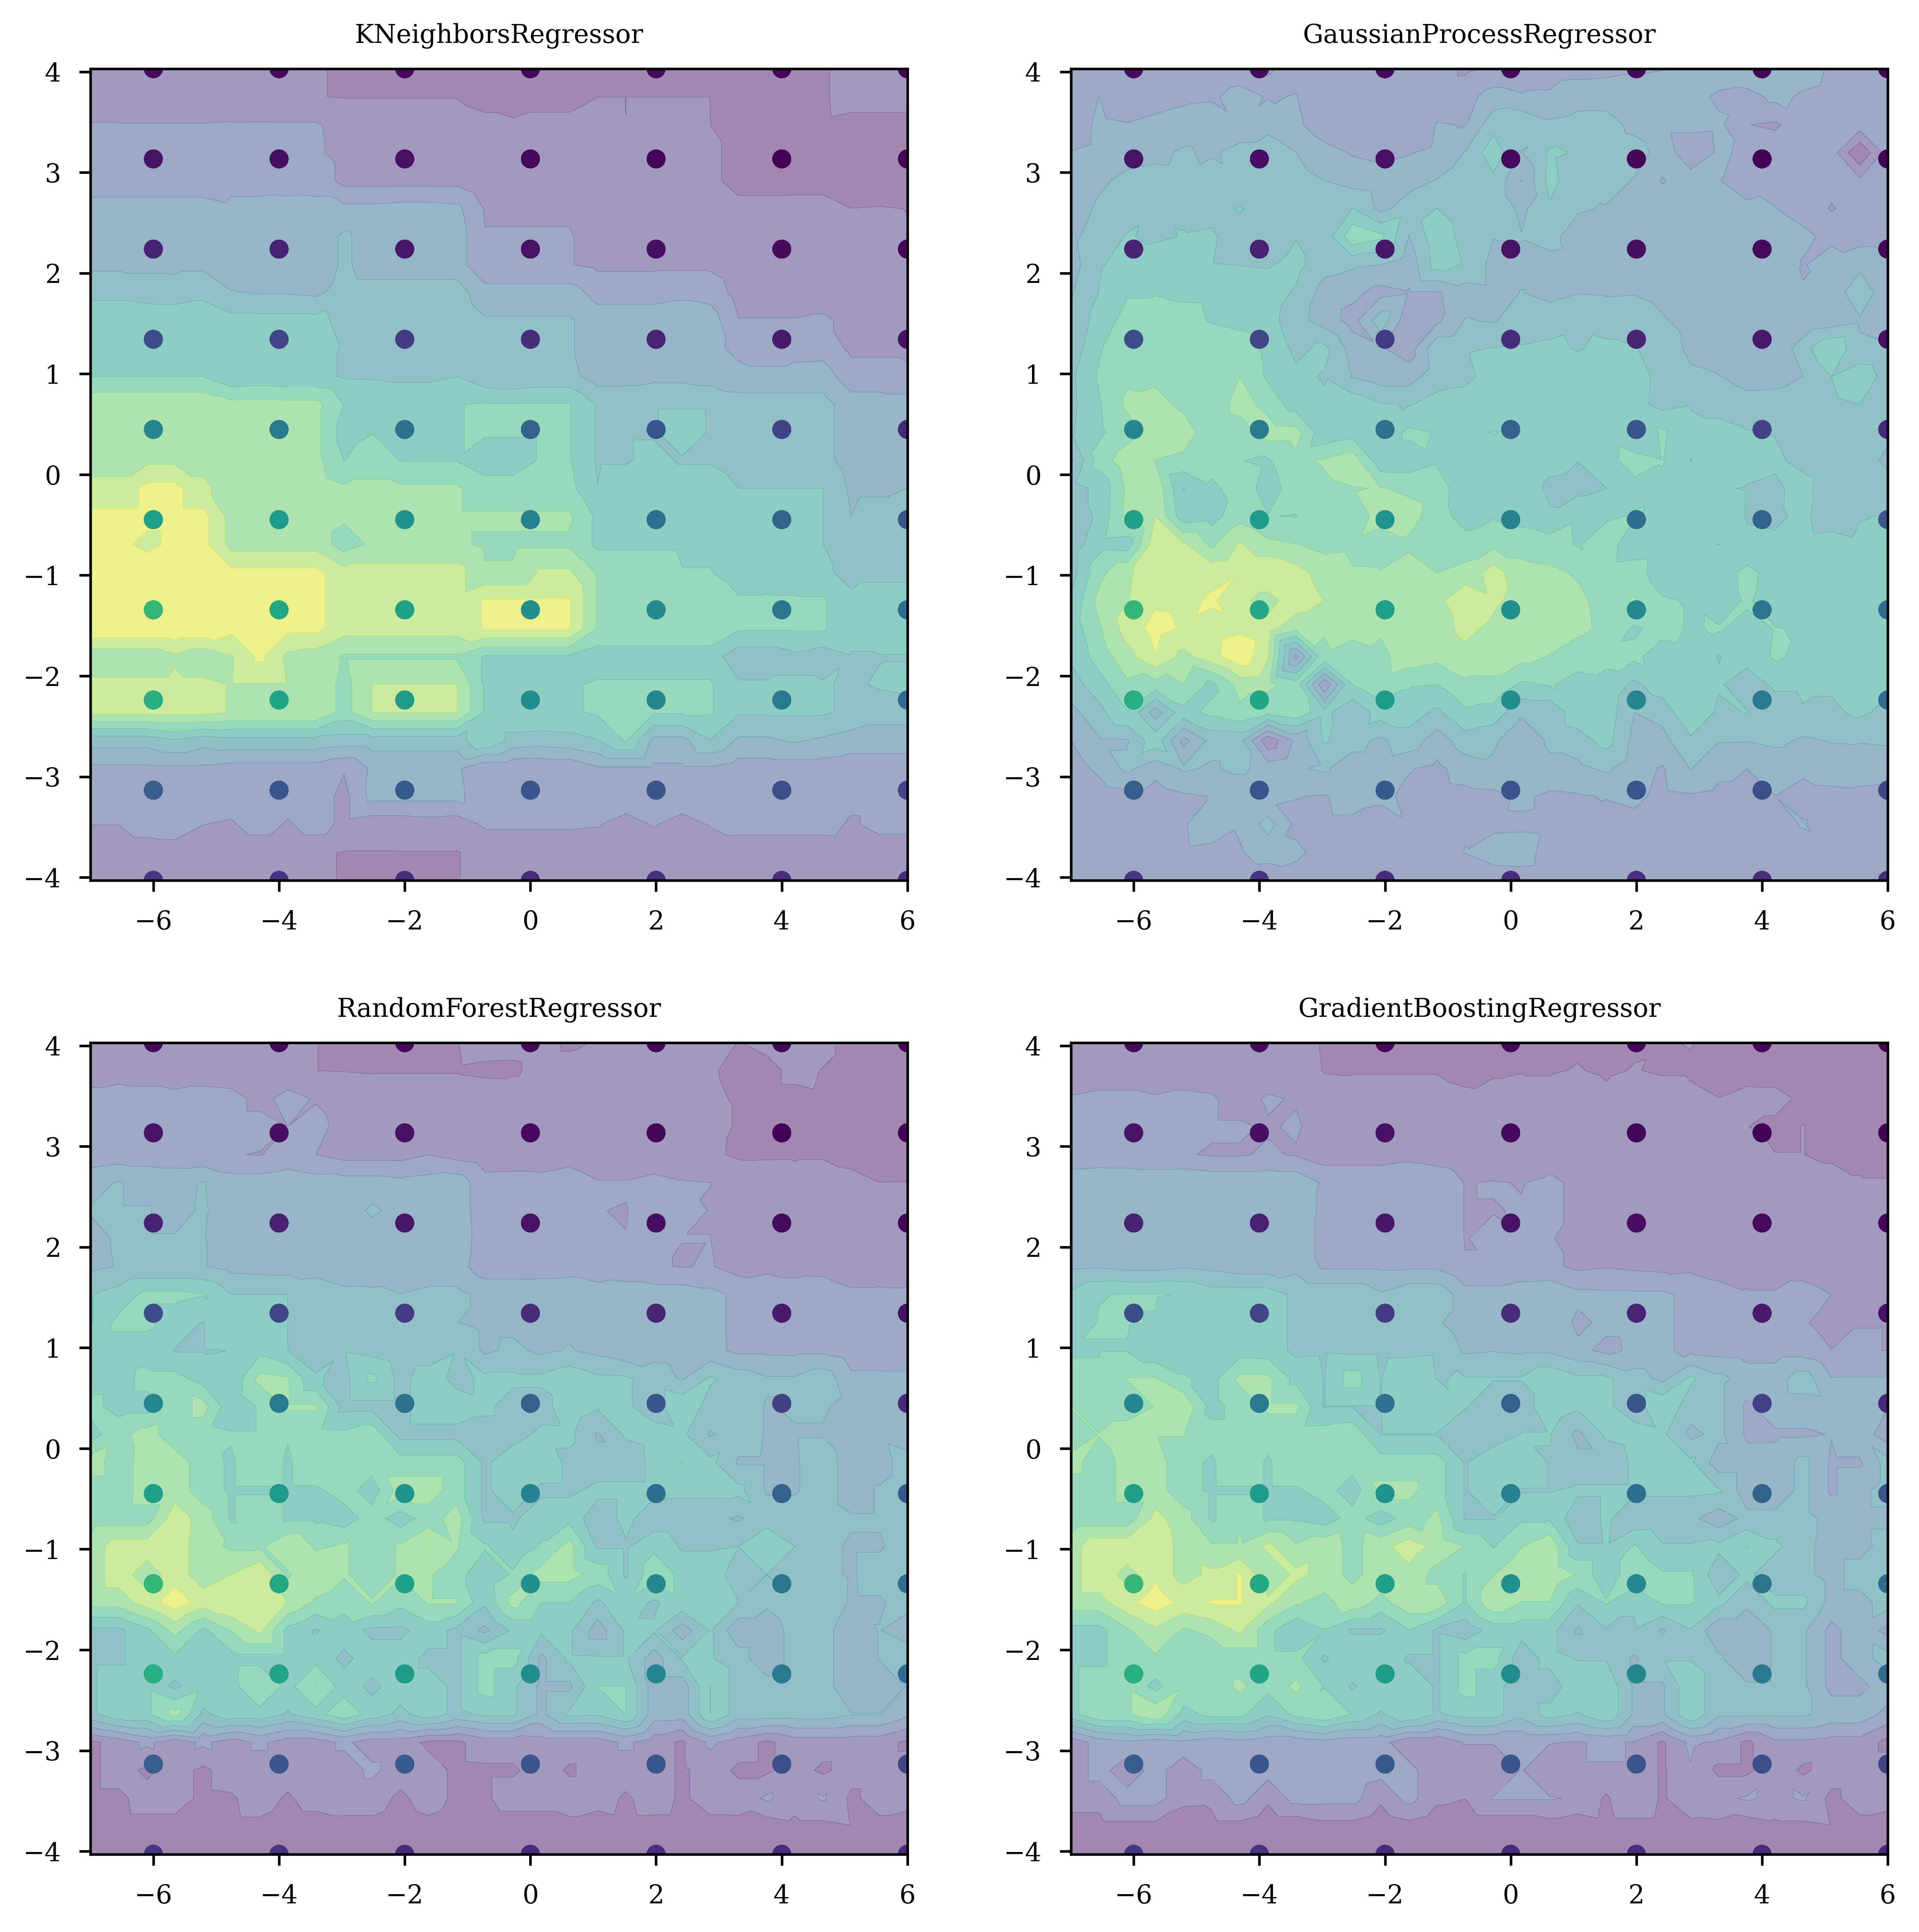

In [72]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
for ax, model in zip(ax, [svr, GPR, RFR, reg]):
    Y_pred = model.predict(test[['L','log-amp', 'lcx']])
    final_mesh = pd.concat([test, pd.DataFrame(Y_pred, columns=['td'])], axis=1)
    transform_mesh = pca.transform(final_mesh[['L', 'log-amp', 'lcx', 'td']])

    ax.tricontourf(transform_mesh[:,0], transform_mesh[:,1], final_mesh['td'], levels=10, alpha = .5)
    ax.scatter(data[:,0], data[:,1], c=results['td'], cmap  = 'viridis')
    ax.set_title(model.__class__.__name__)



KeyError: "['td'] not found in axis"

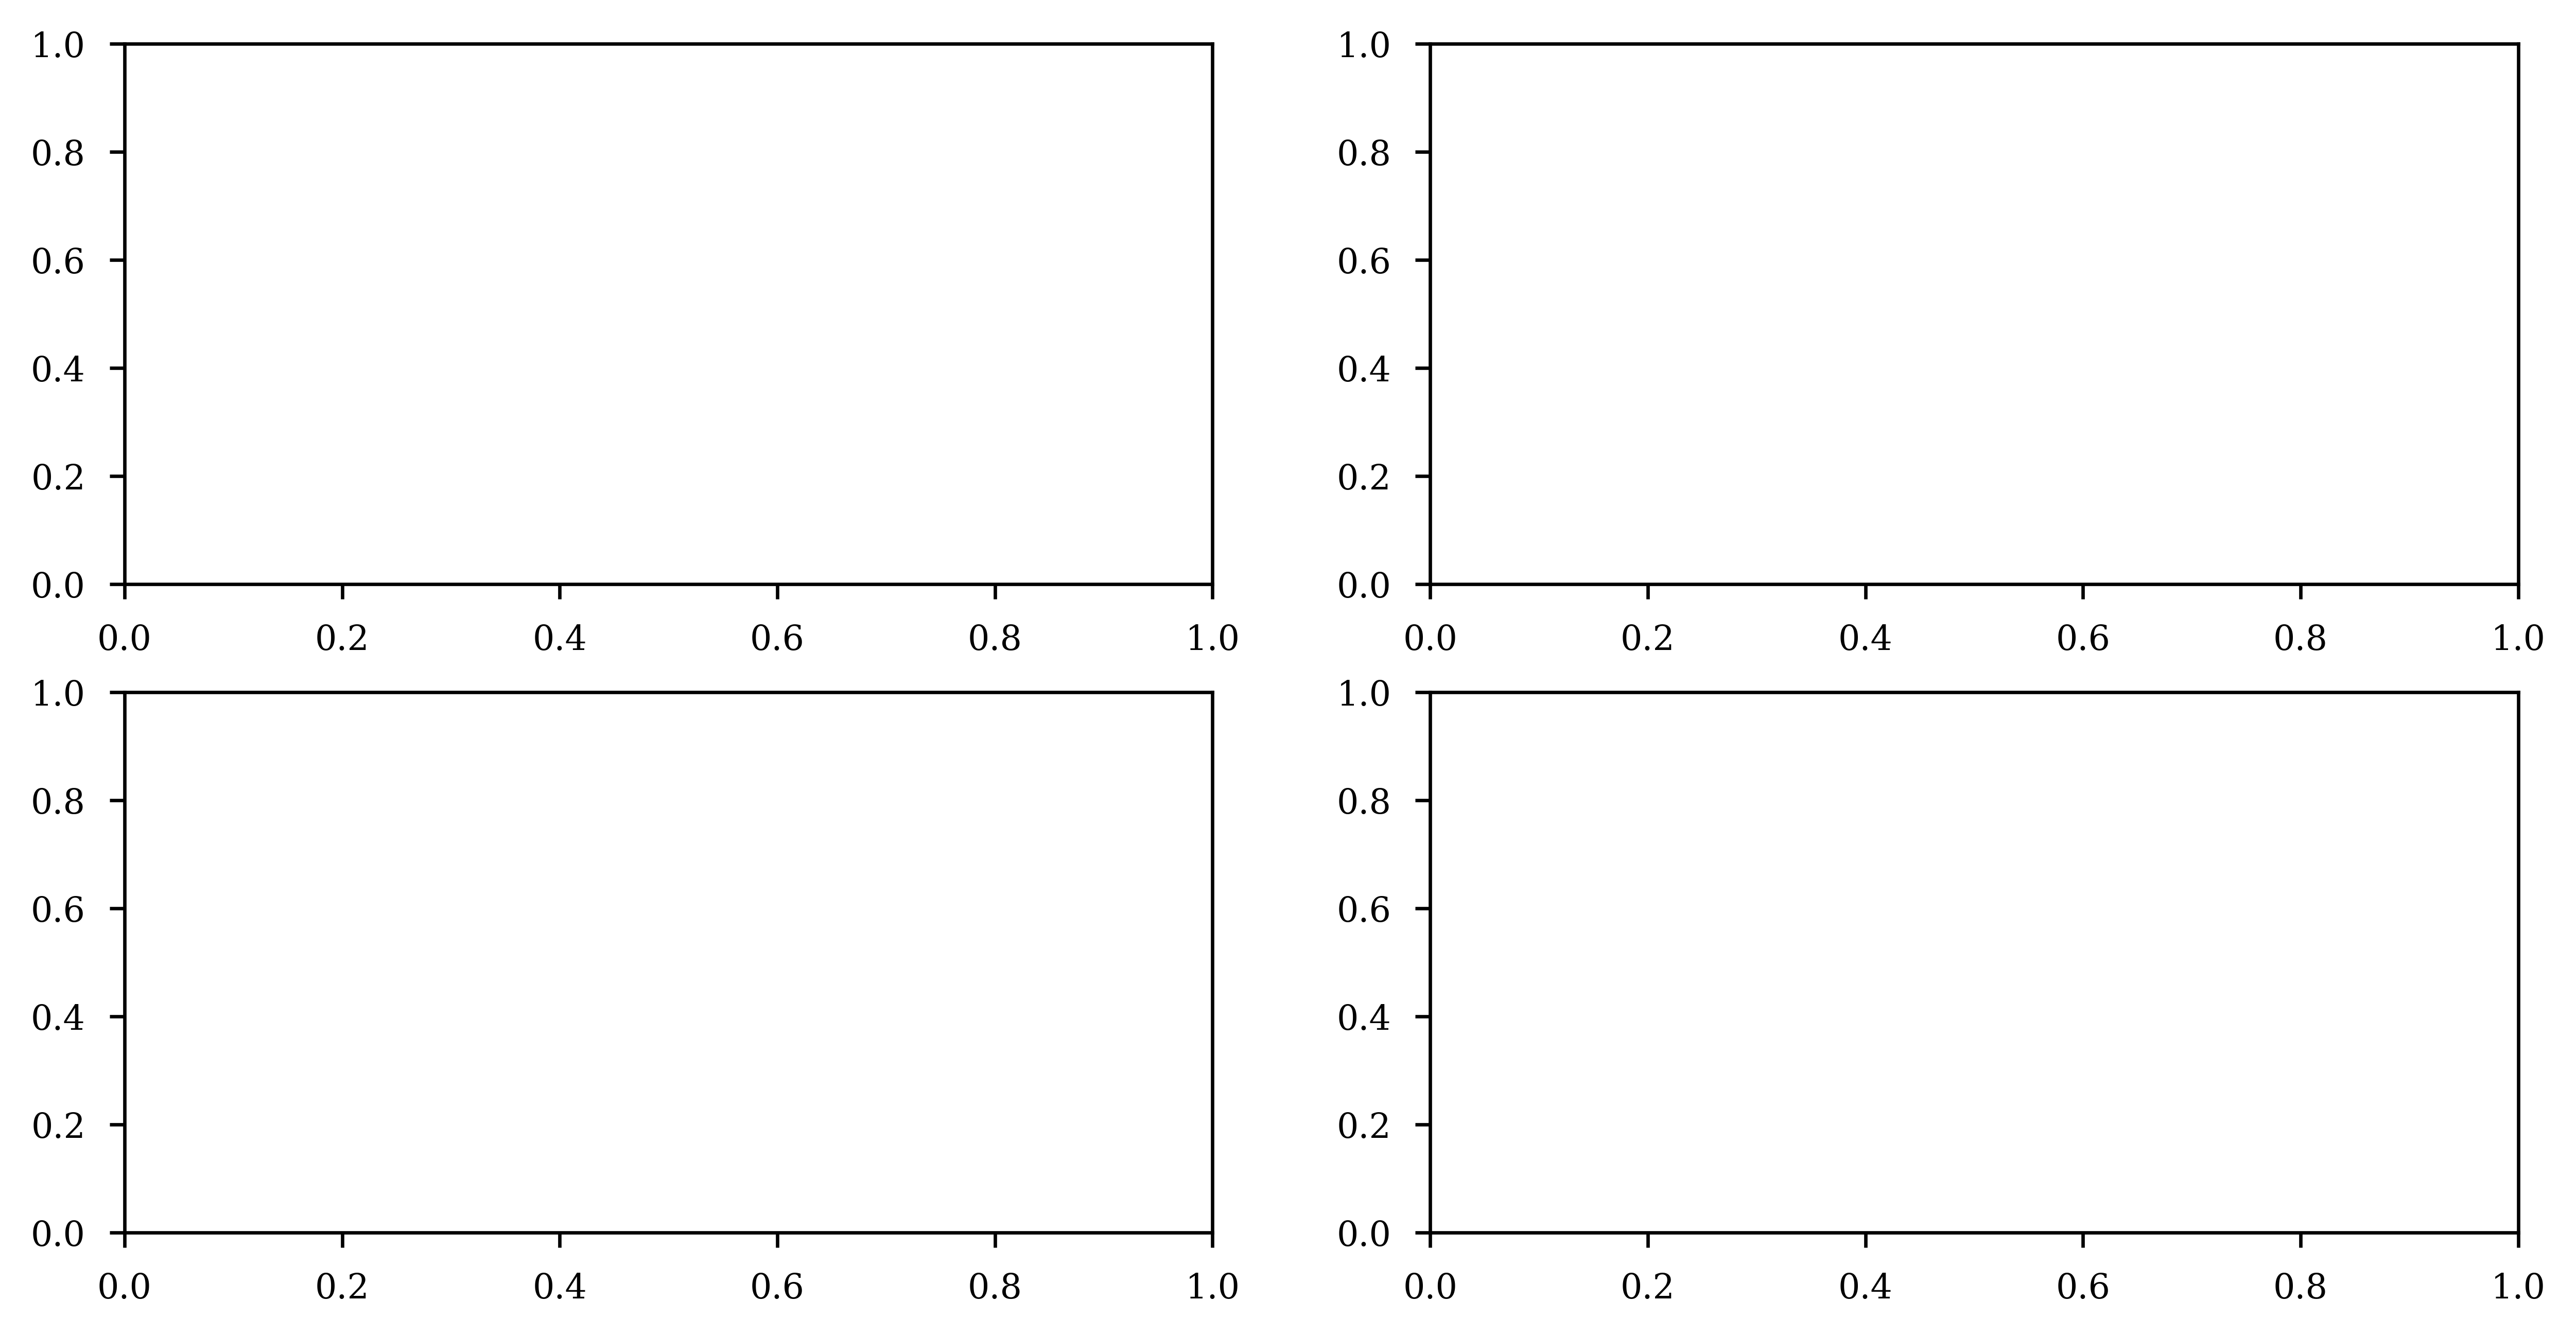

In [58]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].scatter(results['log-amp'], reg.predict(results.drop(columns = ['td'])), alpha = .1, label = 'GradientBoostingRegressor')

ax[1].scatter(results['log-amp'], RFR.predict(results.drop(columns = ['td'])), alpha = .1, color = 'green', label = 'RandomForestRegressor')
ax[2].scatter(results['log-amp'], GPR.predict(results.drop(columns = ['td'])), alpha = .1, color = 'orange', label = 'GaussianProcessRegressor')
ax[3].scatter(results['log-amp'], svr.predict(results.drop(columns = ['td'])), alpha = .1, color = 'red', label = 'KNeighborsRegressor')

for a in ax:

    a.scatter(results['log-amp'], results['td'], alpha = .5, facecolor = 'none', edgecolor = 'black', lw = .5, zorder = 0, label = 'real td')
    a.legend()
fig.supxlabel('log-amplitude')
fig.supylabel('Predicted td')

Text(0.02, 0.5, 'Predicted td')

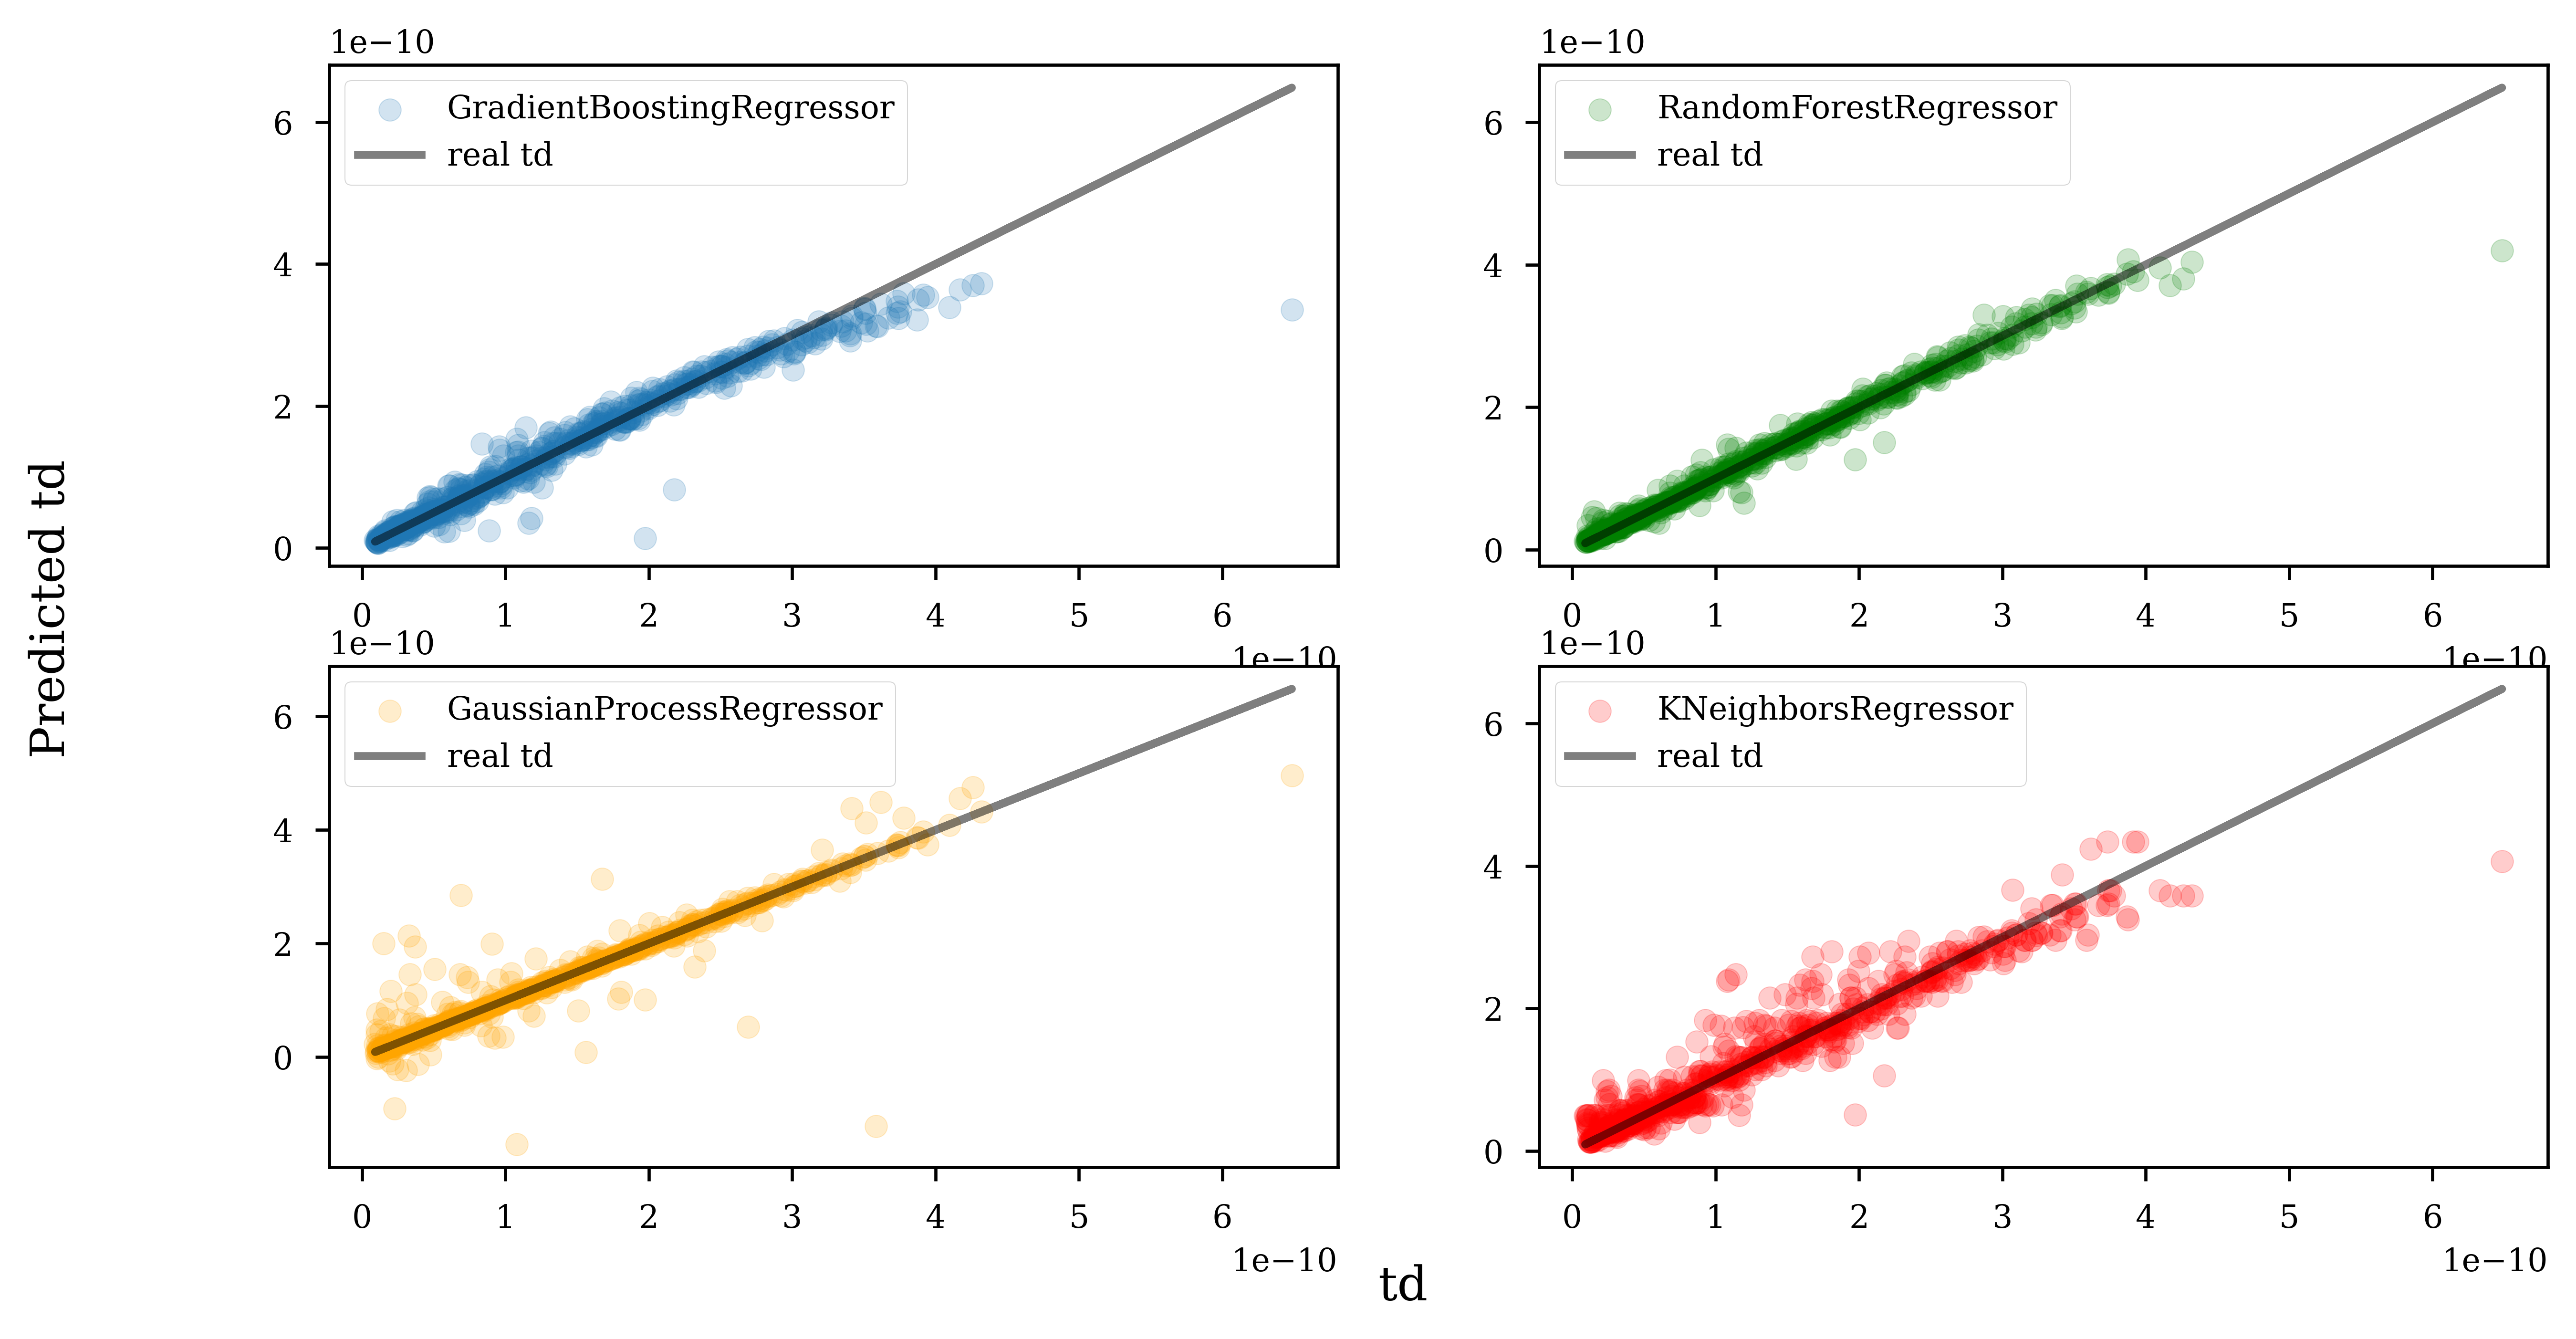

In [70]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].scatter(results['td'], reg.predict(results.drop(columns = ['td'])), alpha = .2, label = 'GradientBoostingRegressor')

ax[1].scatter(results['td'], RFR.predict(results.drop(columns = ['td'])), alpha = .2, color = 'green', label = 'RandomForestRegressor')
ax[2].scatter(results['td'], GPR.predict(results.drop(columns = ['td'])), alpha = .2, color = 'orange', label = 'GaussianProcessRegressor')
ax[3].scatter(results['td'], svr.predict(results.drop(columns = ['td'])), alpha = .2, color = 'red', label = 'KNeighborsRegressor')

for a in ax:

    a.plot(results['td'], results['td'], alpha = .5, label = 'real td', color = 'black')
    a.legend()
fig.supxlabel('td')
fig.supylabel('Predicted td')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].scatter(results['log-amp'], reg.predict(results.drop(columns = ['td'])), alpha = .1, label = 'GradientBoostingRegressor')

ax[1].scatter(results['log-amp'], RFR.predict(results.drop(columns = ['td'])), alpha = .1, color = 'green', label = 'RandomForestRegressor')
ax[2].scatter(results['log-amp'], GPR.predict(results.drop(columns = ['td'])), alpha = .1, color = 'orange', label = 'GaussianProcessRegressor')
ax[3].scatter(results['log-amp'], svr.predict(results.drop(columns = ['td'])), alpha = .1, color = 'red', label = 'KNeighborsRegressor')

for a in ax:

    a.scatter(results['log-amp'], results['td'], alpha = .5, facecolor = 'none', edgecolor = 'black', lw = .5, zorder = 0, label = 'real td')
    a.legend()
fig.supxlabel('log-amplitude')
fig.supylabel('Predicted td')